In [1]:
import pandas as pd
import numpy as np
from imp import reload

from sklearn.cluster import DBSCAN
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV, ParameterGrid
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

import graphviz 
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff
import plotly
import matplotlib.pyplot as plt

from backend import data_handling; reload(data_handling);
from backend import tree_utils; reload(tree_utils);

plotly.offline.init_notebook_mode(connected=True)

C:\Users\Ivan\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Ivan\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\Ivan\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
clients = pd.read_csv('data/clients.csv', sep=';', encoding='cp1251')
trans = pd.read_csv('data/transactions_fixprice_only.csv', sep=';', encoding='cp1251')
categories = pd.read_csv('data/client_categories.csv', sep=';', encoding='cp1251')

In [3]:
categories.head()

,category,description
0,10,VIP/ Management recommendations
1,11,VIP/ Management recommendations (family)
2,17,Private Banking customers walk-in
3,18,Private banking customers payroll
4,20,High income individuals


In [4]:
clients.head()

,cnum_,categorycode,gender,age,married_,residenttype
0,0CCCDO,81,M,32,not_married,R
1,0CCCFO,70,F,42,not_married,R
2,0CCCGC,50,F,33,married,R
3,0CCCGG,70,M,58,not_married,R
4,0CCCGO,60,M,38,married,R


In [5]:
trans.head()

,purchdate,amount,mcc,mrchcity,mrchname,cnum
0,2019-09-23,20582.0,5311,TEMRYUK,94NWJ4I1 B6F5,ELHHAC
1,2019-10-23,14460.0,5311,KRASNODAR,94NWJ4I1 QPGS,ELHHAC
2,2019-10-08,12889.7,5311,TULA,94NWJ4I1 B6MF,EEI105
3,2019-10-11,11981.0,5311,KOLCZOVO,94NWJ4I1 5GPM,EL97DD
4,2019-11-30,11781.0,5311,YASNOGORSK,94NWJ4I1 QBPQ,ELEL21


In [6]:
revenue = trans.groupby('cnum')[['amount']].sum().reset_index()
orders = trans.groupby('cnum')[['amount']].count().reset_index()
orders = orders.rename({'amount' : 'orders'}, axis=1)

client_info = pd.merge(left=revenue, right=orders, on='cnum')
client_info['average_check'] = client_info['amount']/client_info['orders']

client_info = pd.merge(left=client_info, right=clients,
                       left_on='cnum', right_on='cnum_')
client_info = client_info.drop('cnum_', axis=1)
client_info['client_cat'] = pd.qcut(client_info['amount'], 4, labels = False)
client_info.head()

,cnum,amount,orders,average_check,categorycode,gender,age,married_,residenttype,client_cat
0,0CCCGC,1120.3,1,1120.3,50,F,33,married,R,3
1,0CCDNG,887.5,1,887.5,50,F,39,married,R,2
2,0CCFDD,2604.6,2,1302.3,50,M,54,married,R,3
3,0CCFFD,497.0,1,497.0,70,M,34,married,R,2
4,0CCFXY,55.0,1,55.0,50,M,59,married,R,0


In [7]:
client_info['gender_cat'] = pd.factorize(client_info['gender'])[0]
client_info['married_cat'] = pd.factorize(client_info['married_'])[0]
client_info['code_cat'] = pd.factorize(client_info['categorycode'])[0]
print(client_info.shape)
client_info.head()

(187497, 13)


,cnum,amount,orders,average_check,categorycode,gender,age,married_,residenttype,client_cat,gender_cat,married_cat,code_cat
0,0CCCGC,1120.3,1,1120.3,50,F,33,married,R,3,0,0,0
1,0CCDNG,887.5,1,887.5,50,F,39,married,R,2,0,0,0
2,0CCFDD,2604.6,2,1302.3,50,M,54,married,R,3,1,0,0
3,0CCFFD,497.0,1,497.0,70,M,34,married,R,2,1,0,1
4,0CCFXY,55.0,1,55.0,50,M,59,married,R,0,1,0,0


### Fit DT model

In [8]:
clf = tree.DecisionTreeRegressor(max_depth=4,min_samples_leaf=500, criterion='friedman_mse')
X = client_info[['code_cat', 'age', 'gender_cat', 'married_cat']]
Y = client_info[['amount']]

clf = clf.fit(X, Y)

feature_names = {
    0 : 'code',
    1 : 'age',
    2 : 'gender',
    3 : 'married'
}

# value_data = pd.DataFrame(columns=['path', 'value', 'sample', 'revenue'])
# search_tree(clf.tree_, 0, '')

tree_utils.get_most_probable_regression_tree_paths(clf, feature_names, 10)

,segment,revenue
0,Женщина;age > 23.5;VIP;age <= 47.5;,6.046738e+07
1,Мужчина;Неженат/незамужем;age > 23.5;Премиальный;,2.624749e+07
2,Женщина;age > 23.5;Не VIP;Премиальный;,2.004088e+07
3,Мужчина;Женат/замужем;Премиальный;VIP;,1.767018e+07
4,Женщина;age > 23.5;VIP;age > 47.5;,1.241547e+07
5,Мужчина;Женат/замужем;Премиальный;Не VIP;,6.871839e+06
6,Женщина;age > 23.5;Не VIP;Не премиальный;,4.484718e+06
7,Женщина;age <= 23.5;age > 20.5;VIP;,3.078337e+06
8,Мужчина;Женат/замужем;Не премиальный;age <= 44.5;,2.963410e+06
9,Мужчина;Женат/замужем;Не премиальный;age > 44.5;,1.724026e+06


In [9]:
# data_handling.save_to_pickle(clf, 'in/fp_segmentation_dt_model.pickle')
# data_handling.save_to_pickle(feature_names, 'in/fp_segmentation_dt_model_features.pickle')

In [20]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=['code_cat', 'age', 'gender_cat', 'married_cat'],  
                                filled=True, rounded=True,  
                                special_characters=True)

graph = graphviz.Source(dot_data) 

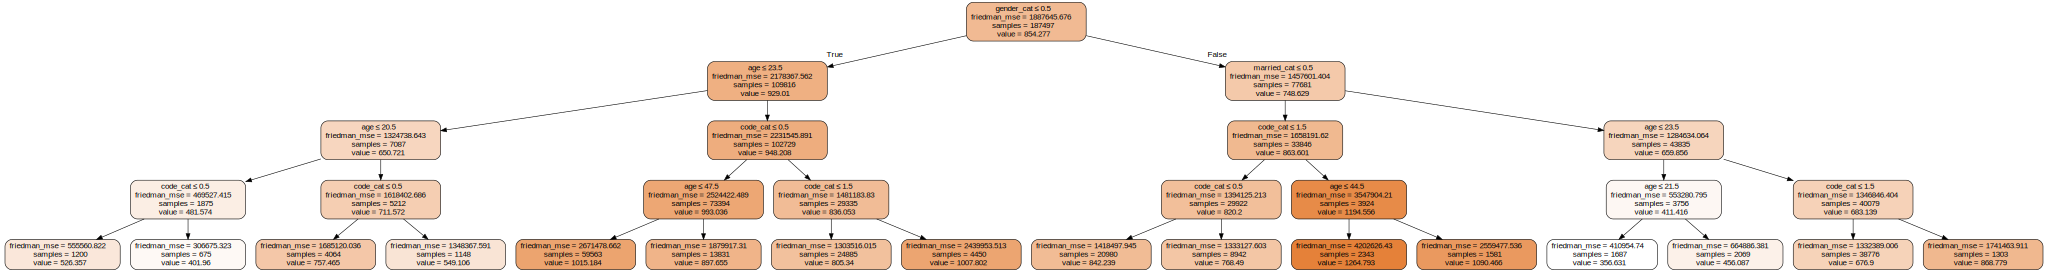

In [21]:
graph

# value = средняя выручка от человека в сегменте
# married = 0
# female = 0

### Fit Random Forest model

In [9]:
clf = RandomForestRegressor(n_estimators=50, max_depth=4, min_samples_leaf=500, criterion='friedman_mse', 
                            random_state=1, n_jobs=-1)
X = client_info[['code_cat', 'age', 'gender_cat', 'married_cat']]
Y = client_info[['amount']]

clf = clf.fit(X, Y)

feature_names = {
    0 : 'code',
    1 : 'age',
    2 : 'gender',
    3 : 'married'
}

# value_data = pd.DataFrame(columns=['path', 'value', 'sample', 'revenue'])
# search_tree(clf.estimators_[0].tree_, 0, '')

tree_utils.get_most_probable_regression_ensemble_paths(clf, feature_names, 5)

C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



,segment,revenue
0,Женщина;age > 22.5;Непремиальный клиент;age > ...,4.281429e+07
1,Женщина;age > 23.5;Непремиальный клиент;age <=...,4.002998e+07
2,Женщина;age > 23.5;Непремиальный клиент;age <=...,3.931268e+07
3,Женщина;age > 23.5;Непремиальный клиент;age <=...,3.903450e+07
4,Женщина;age > 25.5;Непремиальный клиент;age <=...,3.872899e+07


In [101]:
# data_handling.save_to_pickle(clf, 'in/fp_segmentation_model.pickle')
# data_handling.save_to_pickle(feature_names, 'in/fp_segmentation_model_features.pickle')